In [1]:
import sys
sys.path.append("./../../src")
from visualizer_helper import Visualizer

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.sparse import csr_matrix
import scipy
import pickle
import os
from annoy import AnnoyIndex
from scipy.sparse.linalg import inv
from collections import Counter

In [2]:
k_neighbors = 100
evecs=50

In [3]:
A = pickle.load(open("./data/A_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

D = pickle.load(open("./data/D_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
D_mc = pickle.load(open("./data/D_mc_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

# D_inv_sqrt = pickle.load(open("./data/D_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "rb"))
# D_mc_inv_sqrt = pickle.load(open("./data/D_mc_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "rb"))

L = pickle.load(open("./data/L_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
L_mc = pickle.load(open("./data/L_mc_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

L_evals = pickle.load(open("./data/L_evals{}_K{}.p".format(evecs, k_neighbors), "rb"))
L_evecs = pickle.load(open("./data/L_evecs{}_K{}.p".format(evecs, k_neighbors), 'rb'))

L_mc_evals = pickle.load(open("./data/L_mc_evals{}_K{}.p".format(evecs, k_neighbors), "rb"))
L_mc_evecs = pickle.load(open("./data/L_mc_evecs{}_K{}.p".format(evecs, k_neighbors), "rb"))

# L_evals_svd = pickle.load(open("./data/L_evals_svd{}_K{}.p".format(evecs, k_neighbors), "rb"))
# L_evecs_svd = pickle.load(open("./data/L_evecs_svd{}_K{}.p".format(evecs, k_neighbors), 'rb'))

# L_mc_evals_svd = pickle.load(open("./data/L_mc_evals_svd{}_K{}.p".format(evecs, k_neighbors), "rb"))
# L_mc_evecs_svd = pickle.load(open("./data/L_mc_evecs_svd{}_K{}.p".format(evecs, k_neighbors), "rb"))

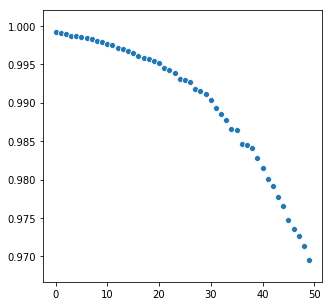

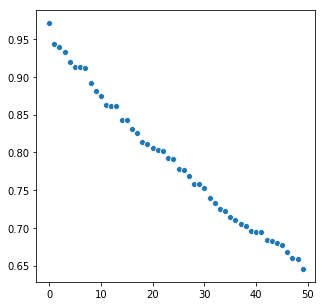

In [5]:
#print(np.flip(L_evals_svd))
plt.figure(figsize=(5,5))
ax = sns.scatterplot(range(L_evals.shape[0]), L_evals)

#print(np.flip(L_mc_evals_svd))
plt.figure(figsize=(5,5))
ax = sns.scatterplot(range(L_mc_evals.shape[0]), L_mc_evals)

In [6]:
def get_evec_df(evecs, top_k_evecs=5):
    k_evecs = evecs[:, -top_k_evecs:]
    evec_cols = ["Evec_{}".format(i) for i in range(top_k_evecs)]
    evec_df = pd.DataFrame(k_evecs, columns=evec_cols)
    return evec_df

describe_topk = 5
L_evecdf = get_evec_df(L_evecs, top_k_evecs=describe_topk)
L_mc_evecdf = get_evec_df(L_mc_evecs, top_k_evecs=describe_topk)

In [7]:
print(L_evecdf.describe())
print(L_mc_evecdf.describe())

             Evec_0        Evec_1        Evec_2        Evec_3        Evec_4
count  44083.000000  44083.000000  44083.000000  44083.000000  44083.000000
mean       0.000096     -0.000137     -0.000827      0.000098     -0.000677
std        0.004762      0.004761      0.004691      0.004762      0.004715
min       -0.123161     -0.171955     -0.163317     -0.173731     -0.151149
25%       -0.000832     -0.000688     -0.001372      0.000049     -0.001164
50%        0.000369     -0.000332     -0.000793      0.000382     -0.000496
75%        0.001356      0.000096     -0.000310      0.000770     -0.000077
max        0.146827      0.194638      0.179721      0.180252      0.206247
             Evec_0        Evec_1        Evec_2        Evec_3        Evec_4
count  4.408300e+04  44083.000000  4.408300e+04  4.408300e+04  4.408300e+04
mean  -1.835728e-04      0.000038  4.183201e-05 -2.273291e-05  2.623756e-04
std    4.759338e-03      0.004763  4.762693e-03  4.762823e-03  4.755644e-03
min   -8.729

In [8]:
def get_Y(evecs, drop_k_evecs = 1, keep_top_k_evecs = 5):
    X_top_k = evecs[:, -drop_k_evecs-keep_top_k_evecs:-drop_k_evecs]
    evecs_lengths_top_k = np.linalg.norm(X_top_k, axis=1)
    Y_top_k = X_top_k / evecs_lengths_top_k[:, None]
    return Y_top_k

keep_k_evecs=8
drop_k_evecs=1
Y = get_Y(L_evecs, drop_k_evecs=drop_k_evecs, keep_top_k_evecs=keep_k_evecs)
Y_mc = get_Y(L_mc_evecs, drop_k_evecs=drop_k_evecs, keep_top_k_evecs=keep_k_evecs)

print(Y.shape, Y_mc.shape)

(44083, 8) (44083, 8)


In [9]:
visualizer = Visualizer()
lc=100

try:
    Y_umap_2d = pickle.load(open("./data/Y_umap_2d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))
    Y_umap_3d = pickle.load(open("./data/Y_umap_3d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))

    Y_mc_umap_2d = pickle.load(open("./data/Y_umap_2d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))
    Y_mc_umap_3d = pickle.load(open("./data/Y_umap_3d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))
except FileNotFoundError:
    print("Error: 1 or more umap files not found")
    Y_umap_2d = visualizer.umap_embedding(Y, n_components=2, lc=lc)
    Y_umap_3d = visualizer.umap_embedding(Y, n_components=3, lc=lc)
    
    Y_mc_umap_2d = visualizer.umap_embedding(Y_mc, n_components=2, lc=lc)
    Y_mc_umap_3d = visualizer.umap_embedding(Y_mc, n_components=3, lc=lc)

    pickle.dump(Y_umap_2d, open("./data/Y_umap_2d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'wb'))
    pickle.dump(Y_umap_3d, open("./data/Y_umap_3d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'wb'))

    pickle.dump(Y_mc_umap_2d, open("./data/Y_umap_2d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'wb'))
    pickle.dump(Y_mc_umap_3d, open("./data/Y_umap_3d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'wb'))

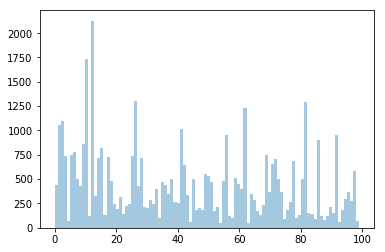

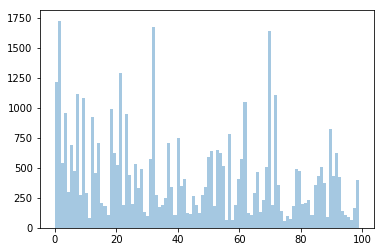

In [10]:
knn_clusters = 100

try:
    Y_cluster_labels = pickle.load(open("./data/cluster_labels_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), 'rb'))
    Y_mc_cluster_labels = pickle.load(open("./data/cluster_labels_mc_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), 'rb'))

except FileNotFoundError:
    print("running Kmeans")
    
    Y_kmeans = KMeans(n_clusters=knn_clusters).fit(Y)
    Y_mc_kmeans = KMeans(n_clusters=knn_clusters).fit(Y_mc)

    Y_cluster_labels = Y_kmeans.labels_    
    Y_mc_cluster_labels = Y_mc_kmeans.labels_

    pickle.dump(Y_cluster_labels, open("./data/cluster_labels_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), "wb"))
    pickle.dump(Y_mc_cluster_labels, open("./data/cluster_labels_mc_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), "wb"))

    print("Cluster labels:", np.unique(Y_cluster_labels))
    
plt.figure()
sns.distplot(Y_cluster_labels, bins=knn_clusters, kde=False)
plt.figure()
sns.distplot(Y_mc_cluster_labels, bins=knn_clusters, kde=False)

In [11]:
### Save cluster assignments
cluster_assignment_df = pd.read_csv("./data/REMAINING_SUBJECT_IDS.csv")

print(Y_cluster_labels.shape)

cluster_assignment_df["CLUSTER"] = Y_cluster_labels
cluster_assignment_df["MC_CLUSTER"] = Y_mc_cluster_labels

print(cluster_assignment_df)
cluster_assignment_df.to_csv("./data/CLUSTER_ASSIGNMENTS.csv", index=None)

(44083,)
       SUBJECT_ID  ORIGINAL_INDEX  CLUSTER  MC_CLUSTER
0             109               0       10          51
1             112               1       82          32
2             113               2       49          23
3             114               3       86          93
4             115               4       98          62
5             117               6       60          32
6             118               7       22          25
7             119               8       73           2
8             122              10       85          44
9             123              11       39          53
10            124              12       41          70
11            125              13        9          79
12            126              14       61           3
13            127              15       95          48
14            128              16       29           8
15            129              17        3          37
16            130              18       50          66
1

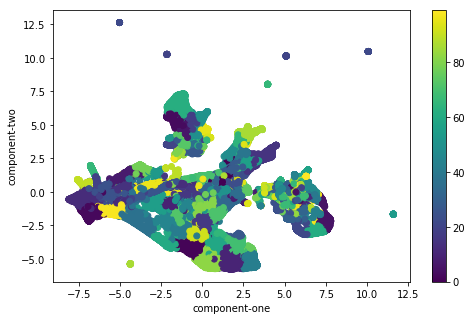

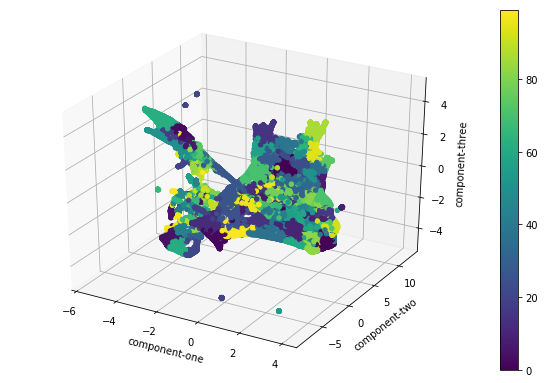

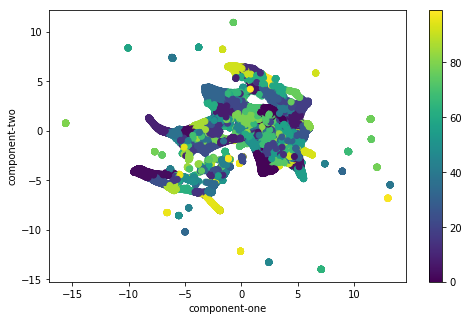

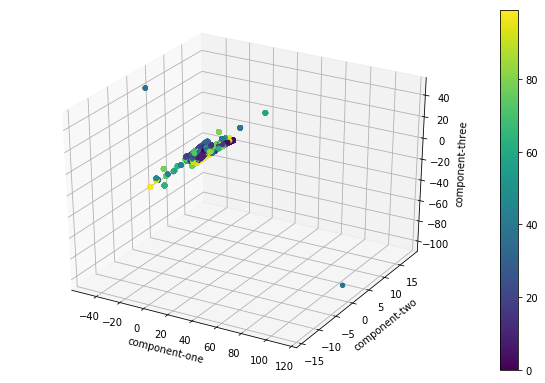

In [12]:
alpha = 1

filename_2d = "./figures/umap2d_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)
filename_3d = "./figures/umap3d_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)   

filename_mc_2d = "./figures/umap2d_mc_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)
filename_mc_3d = "./figures/umap3d_mc_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)

visualizer.plot2d(
    X=Y_umap_2d, 
    filename=filename_2d, 
    colors=Y_cluster_labels,
    alpha = alpha
)

visualizer.plot3d(
    X=Y_umap_3d, 
    filename=filename_3d, 
    colors=Y_cluster_labels,
    alpha = alpha
)

visualizer.plot2d(
    X=Y_mc_umap_2d, 
    filename=filename_mc_2d, 
    colors=Y_mc_cluster_labels,
    alpha = alpha
)
visualizer.plot3d(
    X=Y_mc_umap_3d, 
    filename=filename_mc_3d, 
    colors=Y_mc_cluster_labels,
    alpha = alpha
)

#PLOT CENTROIDS FOR K MEANS
#PLOT SOME MEMBERS FROM EACH CENTROID


# Cluster Centroids

In [13]:
def compute_centroids(y, cluster_labels):
    centroids = []
    cluster_memberships = {}
    for idx, c in enumerate(cluster_labels):
        if c not in cluster_memberships:
            cluster_memberships[c] = [idx]
        else:
            cluster_memberships[c].append(idx)
    
    unique_labels = np.unique(cluster_labels)
    for c in tqdm(unique_labels):
        cluster_c_idx = cluster_memberships[c]
        cluster_c_embeddings = y[cluster_c_idx]
        if len(cluster_c_embeddings > 0):
            centroids.append(np.mean(cluster_c_embeddings, axis=0))
    return np.array(centroids)

Y_c_umap_2d = compute_centroids(Y_umap_2d, Y_cluster_labels)
Y_c_umap_3d = compute_centroids(Y_umap_3d, Y_cluster_labels)
Y_mc_c_umap_2d = compute_centroids(Y_mc_umap_2d, Y_mc_cluster_labels)
Y_mc_c_umap_3d = compute_centroids(Y_mc_umap_3d, Y_mc_cluster_labels)

100%|██████████| 100/100 [00:00<00:00, 12144.73it/s]


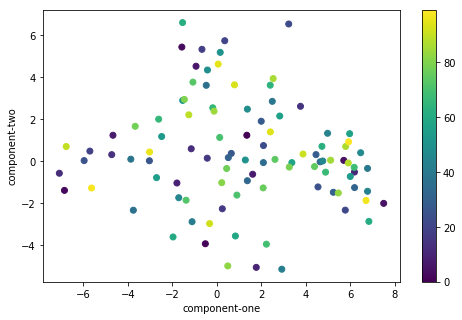

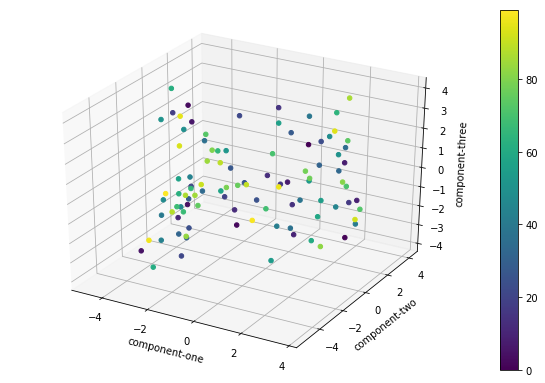

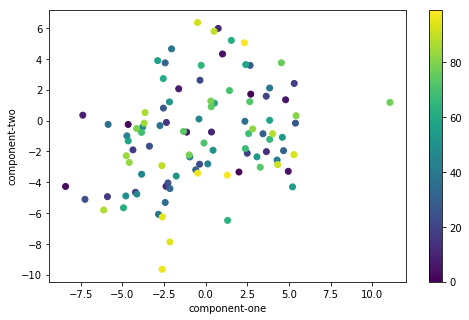

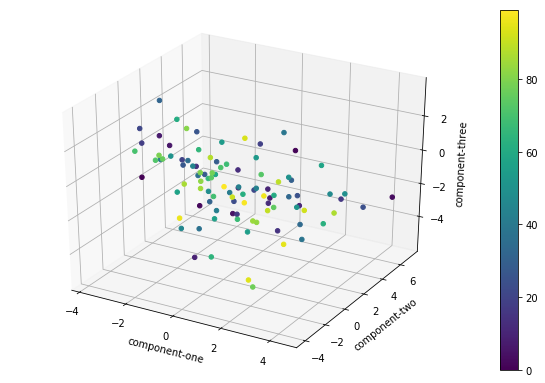

In [14]:
alpha = 1

filename_2d = "./figures/centroids2d_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)
filename_3d = "./figures/centroids3d_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)   

filename_mc_2d = "./figures/centroids2d_mc_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)
filename_mc_3d = "./figures/centroids3d_mc_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)

colors = range(knn_clusters)

visualizer.plot2d(
    X=Y_c_umap_2d, 
    filename=filename_2d, 
    colors=colors,
    alpha = alpha
)

visualizer.plot3d(
    X=Y_c_umap_3d, 
    filename=filename_3d, 
    colors=colors,
    alpha = alpha
)

visualizer.plot2d(
    X=Y_mc_c_umap_2d, 
    filename=filename_mc_2d, 
    colors=colors,
    alpha = alpha
)
visualizer.plot3d(
    X=Y_mc_c_umap_3d, 
    filename=filename_mc_3d, 
    colors=colors,
    alpha = alpha
)

100%|██████████| 100/100 [00:00<00:00, 5868.62it/s]
./../../src/visualizer_helper.py:22: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  return UMAP(n_components=n_components, local_connectivity=lc).fit_transform(X)
./../../src/visualizer_helper.py:22: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  return UMAP(n_components=n_components, local_connectivity=lc).fit_transform(X)


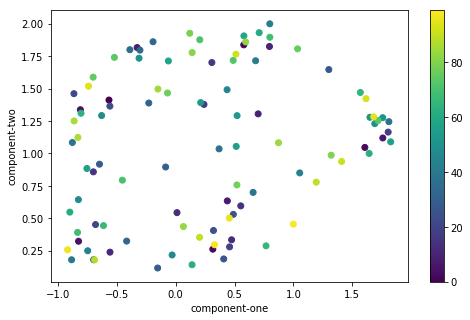

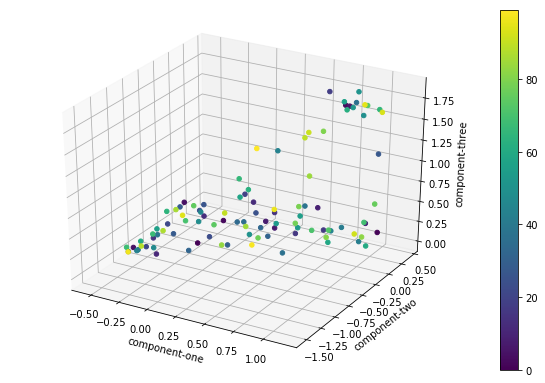

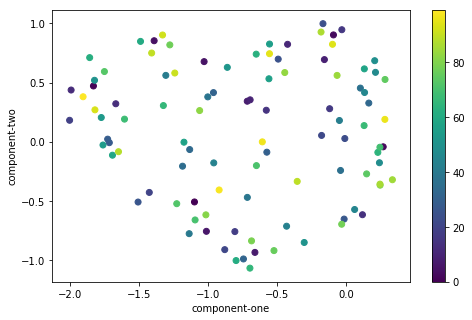

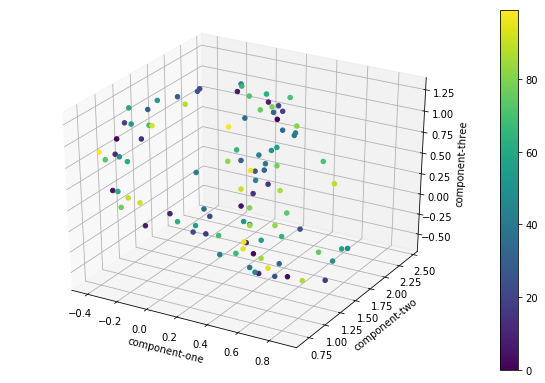

In [15]:
lc=100

Y_centroids = compute_centroids(Y, Y_cluster_labels)
Y_mc_centroids = compute_centroids(Y_mc, Y_mc_cluster_labels)

Y_centroid_umap_2d = visualizer.umap_embedding(Y_centroids, n_components=2, lc=lc)
Y_centroid_umap_3d = visualizer.umap_embedding(Y_centroids, n_components=3, lc=lc)

Y_mc_centroid_umap_2d = visualizer.umap_embedding(Y_mc_centroids, n_components=2, lc=lc)
Y_mc_centroid_umap_3d = visualizer.umap_embedding(Y_mc_centroids, n_components=3, lc=lc)

alpha = 1
colors = range(knn_clusters)
filename="./figures/dummy"

visualizer.plot2d(
    X=Y_centroid_umap_2d, 
    filename=filename, 
    colors=colors,
    alpha = alpha
)

visualizer.plot3d(
    X=Y_centroid_umap_3d, 
    filename=filename, 
    colors=colors,
    alpha = alpha
)

visualizer.plot2d(
    X=Y_mc_centroid_umap_2d, 
    filename=filename, 
    colors=colors,
    alpha = alpha
)
visualizer.plot3d(
    X=Y_mc_centroid_umap_3d, 
    filename=filename, 
    colors=colors,
    alpha = alpha
)

In [ ]:
def sort_by_cluster_membership(M, cluster_labels):
    sorted_cluster_labels = sorted(list(enumerate(cluster_labels.tolist())), key=lambda p: p[1])
    clusters_by_idx = [p[0] for p in sorted_cluster_labels]
    return M[clusters_by_idx][:, clusters_by_idx]

def sort_by_top_k_cluster_membership(M, k, cluster_labels, exclude=2):    
    
    top_cluster_and_counts = Counter(cluster_labels).most_common(k + exclude)
    print(top_cluster_and_counts)
    top_cluster_and_counts = top_cluster_and_counts[exclude:]
    print("...".format(exclude), top_cluster_and_counts)
    most_common_clusters = [c[0] for c in top_cluster_and_counts]

    sorted_cluster_labels = sorted(list(enumerate(cluster_labels.tolist())), key=lambda p: p[1])
    
    sorted_cluster_labels_filtered = [p for p in sorted_cluster_labels if p[1] in most_common_clusters]
    clusters_by_idx = [p[0] for p in sorted_cluster_labels_filtered]
    return M[clusters_by_idx][:, clusters_by_idx]
    
L_sorted = sort_by_cluster_membership(L, Y_cluster_labels)
L_mc_sorted = sort_by_cluster_membership(L_mc, Y_mc_cluster_labels)

A_sorted = sort_by_cluster_membership(A, Y_cluster_labels)
A_mc_sorted = sort_by_cluster_membership(A, Y_mc_cluster_labels)

topk_clusters = 3
exclude_topk = 0
A_sorted_topk = sort_by_top_k_cluster_membership(A, topk_clusters, Y_cluster_labels, exclude_topk)
L_sorted_topk = sort_by_top_k_cluster_membership(L, topk_clusters, Y_cluster_labels, exclude_topk)

A_mc_sorted_topk = sort_by_top_k_cluster_membership(A, topk_clusters, Y_mc_cluster_labels, exclude_topk)
L_mc_sorted_topk = sort_by_top_k_cluster_membership(L_mc, topk_clusters, Y_mc_cluster_labels, exclude_topk)

print(L_sorted.shape, A_sorted.shape, L_mc_sorted.shape, A_mc_sorted.shape)
print(L_sorted_topk.shape, A_sorted_topk.shape, L_mc_sorted_topk.shape, A_mc_sorted_topk.shape)

# Heatmaps

In [ ]:
##Full Heatmaps
plot_vars = [A_sorted_topk, A_mc_sorted_topk, L_sorted_topk, L_mc_sorted_topk]
plot_var_names = ['A_sorted_topk', 'A_mc_sorted_topk', 'L_sorted_topk', 'L_mc_sorted_topk']
for v in range(len(plot_vars)):
    var = plot_vars[v]
    varname = plot_var_names[v]

    plotmax = var.log1p().log1p().max()/2.0
    plt.figure(figsize=(20,16))
    sns.heatmap(var.log1p().log1p().toarray(), cmap="Reds", vmax=plotmax)
    plt.savefig("./figures/heatmap_{}_K{}_knn{}_kevecs{}.png".format(varname, k_neighbors, knn_clusters, keep_k_evecs))